# Generative adversarial networks with MNIST dataset

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [10]:
os.chdir("/content/drive/MyDrive/Data-driven AI/")
if not os.path.exists("./modified3"):
  os.makedirs("./modified3")


## Create the discriminator

In [11]:
discriminator = keras.Sequential(
    [
        # input
        keras.Input(shape=(32, 32, 3)),

        # Conv2D layer
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        # Conv2D layer
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        # Conv2D layer
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        # Conv2D layer
        layers.Conv2D(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        # Flatten layer
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)       

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [12]:
latent_dim = 32

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(256 * 4 * 4),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              135168    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                              

## Override `train_step`

In [13]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )
        # Add random noise to the labels - important trick!
        #labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [14]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=2):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Train the GAN

In [15]:
# load the images into memory
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images.astype("float32")
train_images = train_images/255
# summarize the shape of the dataset
print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


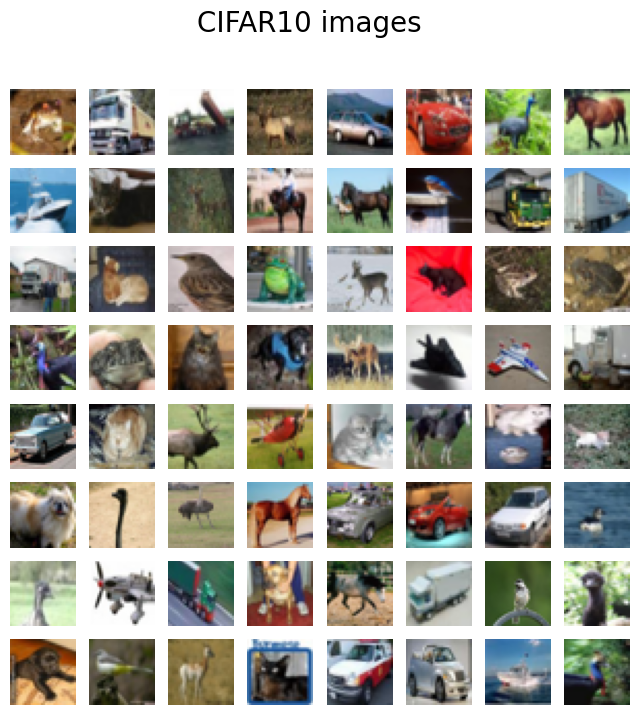

In [16]:
plt.figure(figsize=(8,8))
# plot images from the training dataset
for i in range(64):
  plt.subplot(8, 8, i+1)
  plt.suptitle('CIFAR10 images', fontsize=20)
  plt.axis('off')
	# plot raw pixel data
  plt.imshow(train_images[i])
plt.show()

In [17]:
if not os.path.exists("./modified3/resdata"):
  os.makedirs("./modified3/resdata")

os.chdir("./modified3/resdata")

In [21]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    #mnist_digits, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)], batch_size=32
    train_images, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)], batch_size=128
)

Epoch 1/50
391/391 [==============================] - 47s 95ms/step - d_loss: 0.6265 - g_loss: 0.9669
Epoch 2/50
391/391 [==============================] - 36s 91ms/step - d_loss: 0.6200 - g_loss: 1.0066
Epoch 3/50
391/391 [==============================] - 35s 91ms/step - d_loss: 0.6144 - g_loss: 1.0283
Epoch 4/50
391/391 [==============================] - 36s 91ms/step - d_loss: 0.6064 - g_loss: 1.0547
Epoch 5/50
391/391 [==============================] - 35s 91ms/step - d_loss: 0.5888 - g_loss: 1.1104
Epoch 6/50
391/391 [==============================] - 35s 91ms/step - d_loss: 0.5958 - g_loss: 1.0754
Epoch 7/50
391/391 [==============================] - 36s 91ms/step - d_loss: 0.6048 - g_loss: 1.0367
Epoch 8/50
391/391 [==============================] - 35s 90ms/step - d_loss: 0.6279 - g_loss: 0.9767
Epoch 9/50
391/391 [==============================] - 35s 90ms/step - d_loss: 0.6418 - g_loss: 0.9298
Epoch 10/50
391/391 [==============================] - 35s 91ms/step - d_loss: 0.6

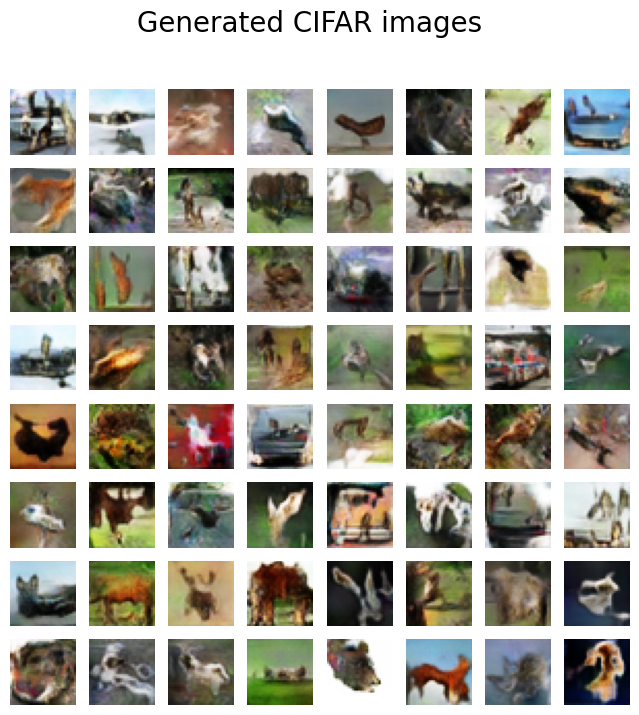

In [22]:
random_latent_vectors = tf.random.normal(shape=(64,latent_dim))
generated_images = gan.generator(random_latent_vectors)

plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)                    # plt.subplot(row, column, index)
    plt.suptitle('Generated CIFAR images', fontsize=20) # 하나의 큰 제목 설정
    plt.imshow(generated_images[i])
    plt.axis("off")

plt.show()

In [23]:
gan.push_to_hub("ssalbab/gan-cifar10-training", use_auth_token=True)

AttributeError: 'GAN' object has no attribute 'push_to_hub'